In [19]:
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
%matplotlib inline

In [95]:
df = pd.read_csv('../vb_data/agg_stations.csv')

In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1006 entries, 0 to 1005
Data columns (total 4 columns):
update       1006 non-null object
free         1006 non-null int64
available    1006 non-null int64
total        1006 non-null int64
dtypes: int64(3), object(1)
memory usage: 31.5+ KB


In [97]:
df['update'] = [datetime.strptime(x, '%Y-%m-%d %H:%M:%S') for x in df['update']]

In [98]:
df.set_index('update', inplace = True)

Our season will be comprised of (24*4) observations, since this is quarter hourly data we can see that every cycle seems more or less to happen over one day. This also makes intuitive sense because 96 quarter hours make one day

In [24]:
24*4

96

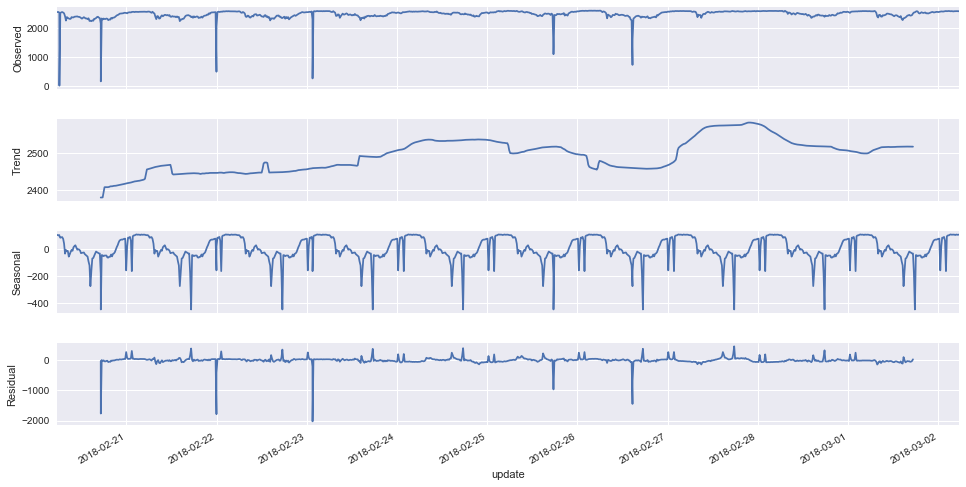

In [25]:
decomposition = seasonal_decompose(df[0:960].available, freq=96)  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

### Dickey-Fuller: empirical method of evaluating whether we've achieved stationarity.
The null hypothesis is that it is not stationary, the alternative hypothesis is that it is stationary. If we reject our null-hypothesis, then we are saying that our timeseries is already stationary and does not need to be differenced. If we fail to reject it, then our timeseries is not stationary, and does need to be differenced.

In [26]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=96)
    rolstd = pd.rolling_std(timeseries, window=96)

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in list(dftest[4].items()):
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

/Users/nmolivo/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=96,center=False).mean()
/Users/nmolivo/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=96,center=False).std()


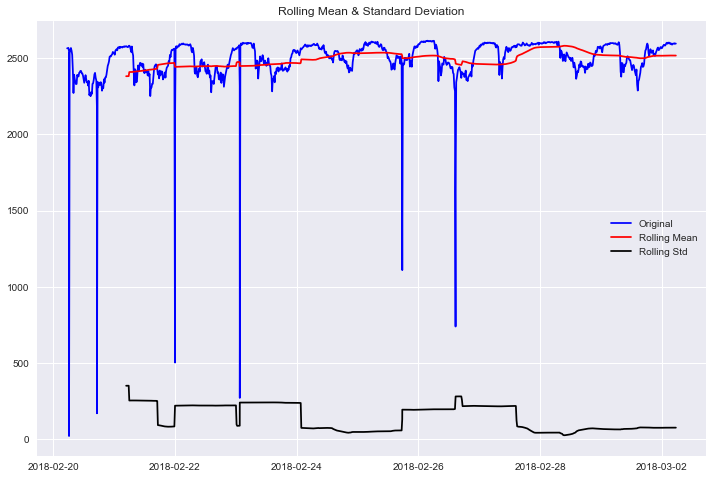

Results of Dickey-Fuller Test:
Test Statistic                -6.448176e+00
p-value                        1.547063e-08
#Lags Used                     8.000000e+00
Number of Observations Used    9.510000e+02
Critical Value (1%)           -3.437245e+00
Critical Value (5%)           -2.864584e+00
Critical Value (10%)          -2.568391e+00
dtype: float64


In [27]:
test_stationarity(df[0:960].available)

/Users/nmolivo/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=96,center=False).mean()
/Users/nmolivo/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=96,center=False).std()


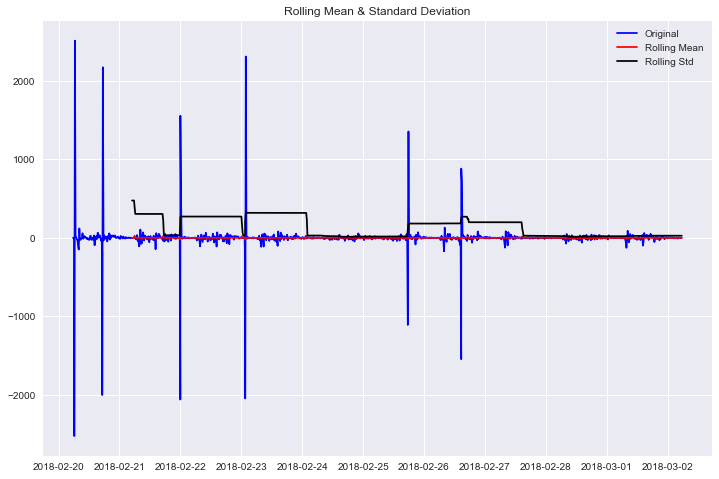

Results of Dickey-Fuller Test:
Test Statistic                -1.309785e+01
p-value                        1.734414e-24
#Lags Used                     1.300000e+01
Number of Observations Used    9.450000e+02
Critical Value (1%)           -3.437289e+00
Critical Value (5%)           -2.864603e+00
Critical Value (10%)          -2.568401e+00
dtype: float64


In [28]:
df['first_difference'] = df[0:960].available - df[0:960].available.shift(1)  
test_stationarity(df.first_difference.dropna(inplace=False))

/Users/nmolivo/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=96,center=False).mean()
/Users/nmolivo/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=96,center=False).std()


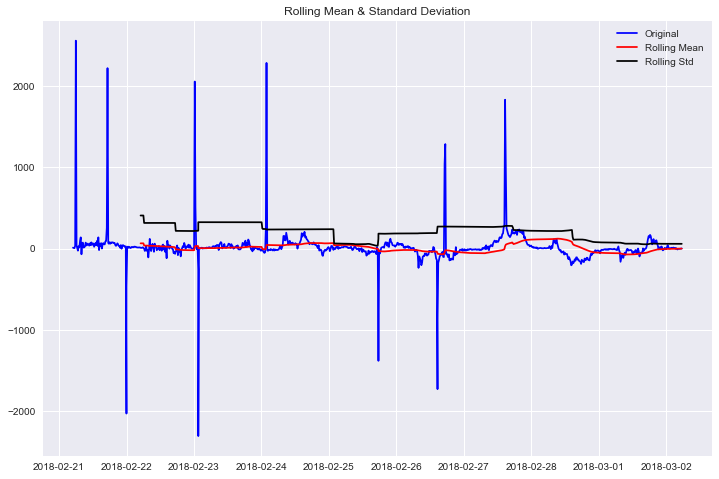

Results of Dickey-Fuller Test:
Test Statistic                -9.302529e+00
p-value                        1.102647e-15
#Lags Used                     6.000000e+00
Number of Observations Used    8.570000e+02
Critical Value (1%)           -3.438003e+00
Critical Value (5%)           -2.864918e+00
Critical Value (10%)          -2.568569e+00
dtype: float64


In [29]:
df['seasonal_difference'] = df[0:960].available - df[0:960].available.shift(96)
test_stationarity(df.seasonal_difference.dropna(inplace=False))

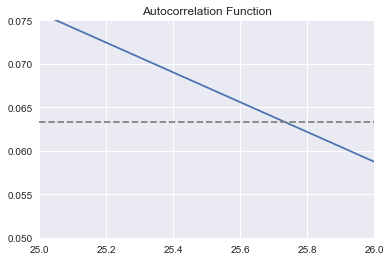

In [66]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(df[0:960].available, nlags=30)
lag_pacf = pacf(df[0:960].available, nlags=10, method='ols')

#Plot ACF: 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df[0:960])),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(df[0:960])),linestyle='--',color='gray')
#plt.xlim([25, 26])
#plt.ylim([0.05, 0.075])
plt.title('Autocorrelation Function')

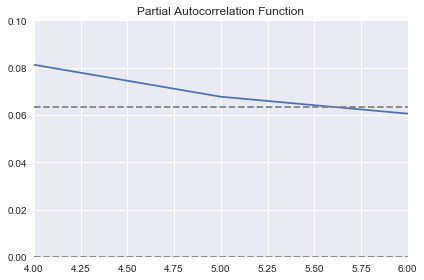

In [68]:
#Plot PACF:
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df[0:960])),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(df[0:960])),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.xlim([4, 6])
plt.ylim([0.0, 0.1])
plt.tight_layout()

p – The lag value where the PACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case p=5.5.<br><Br>
q – The lag value where the ACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case q=25.75.<br><Br>
source: https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/

In [108]:
mod = sm.tsa.statespace.SARIMAX(df[0:960].available, trend='n', order=(6,0,26), seasonal_order=(1,1,7,24), enforce_stationarity = False, enforce_invertibility = False)
results = mod.fit()
results.summary()

/Users/nmolivo/anaconda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                  Statespace Model Results                                 
===========================================================================================
Dep. Variable:                           available   No. Observations:                  960
Model:             SARIMAX(6, 0, 26)x(1, 1, 7, 24)   Log Likelihood               -4706.878
Date:                             Tue, 20 Mar 2018   AIC                           9495.757
Time:                                     22:52:50   BIC                           9695.301
Sample:                                 02-20-2018   HQIC                          9571.748
                                      - 03-02-2018                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4021      0.385      1.044      0.296      -0.353       1.157
ar.L2          0.6370      0.237      2.683      0.007       0.172       1.102
ar.L3         -0.2451      0.296     -0.829      0.407      -0.825       0.334
ar.L4         -0.1195      0.221     -0.541      0.588      -0.552       0.313
ar.L5          0.1367      0.266      0.514      0.608      -0.385       0.658
ar.L6          0.1298      0.250      0.519      0.604      -0.360       0.620
ma.L1          0.0127      0.387      0.033      0.974      -0.746       0.772
ma.L2         -0.6889      0.249     -2.771      0.006      -1.176      -0.202
ma.L3          0.0304      0.327      0.093      0.926      -0.611       0.672
ma.L4          0.2064      0.190      1.084      0.278      -0.167       0.579
ma.L5         -0.0623      0.289     -0.216      0.829      -0.628       0.504
ma.L6         -0.1812      0.233     -0.776      0.438      -0.639       0.276
ma.L7         -0.0332      0.134     -0.248      0.804      -0.296       0.230
ma.L8          0.0260      0.129      0.202      0.840      -0.226       0.278
ma.L9         -0.0485      0.120     -0.405      0.686      -0.283       0.186
ma.L10        -0.0232      0.116     -0.199      0.842      -0.251       0.205
ma.L11         0.0119      0.153      0.078      0.938      -0.287       0.311
ma.L12        -0.0074      0.188     -0.039      0.969      -0.376       0.361
ma.L13         0.0029      0.137      0.021      0.983      -0.266       0.272
ma.L14        -0.0021      0.163     -0.013      0.990      -0.321       0.317
ma.L15        -0.0140      0.110     -0.128      0.898      -0.229       0.201
ma.L16         0.0142      0.132      0.108      0.914      -0.245       0.274
ma.L17         0.0161      0.127      0.127      0.899      -0.232       0.265
ma.L18        -0.0074      0.111     -0.067      0.947      -0.225       0.211
ma.L19         0.0072      0.171      0.042      0.967      -0.328       0.342
ma.L20         0.0142      0.161      0.088      0.930      -0.301       0.329
ma.L21        -0.0271      0.184     -0.147      0.883      -0.388       0.334
ma.L22        -0.0215      0.149     -0.145      0.885      -0.313       0.270
ma.L23         0.0149      0.135      0.111      0.912      -0.249       0.279
ma.L24        -0.3214      0.404     -0.795      0.427      -1.114       0.471
ma.L25        -0.0350      0.140     -0.249      0.803      -0.310       0.240
ma.L26         0.1822      0.289      0.630      0.529      -0.385       0.749
ar.S.L24       0.3447      0.154      2.236      0.025       0.043       0.647
ma.S.L24      -0.9043      0.411     -2.199      0.028      -1.710      -0.098
ma.S.L48      -0.0613      0.241     -0.254      0.799      -0.533       0.411
ma.S.L72       0.0522      0.108      0.486      0.627      -0.158       0.263
ma.S.L96      -0.0218      0.043     -0.503

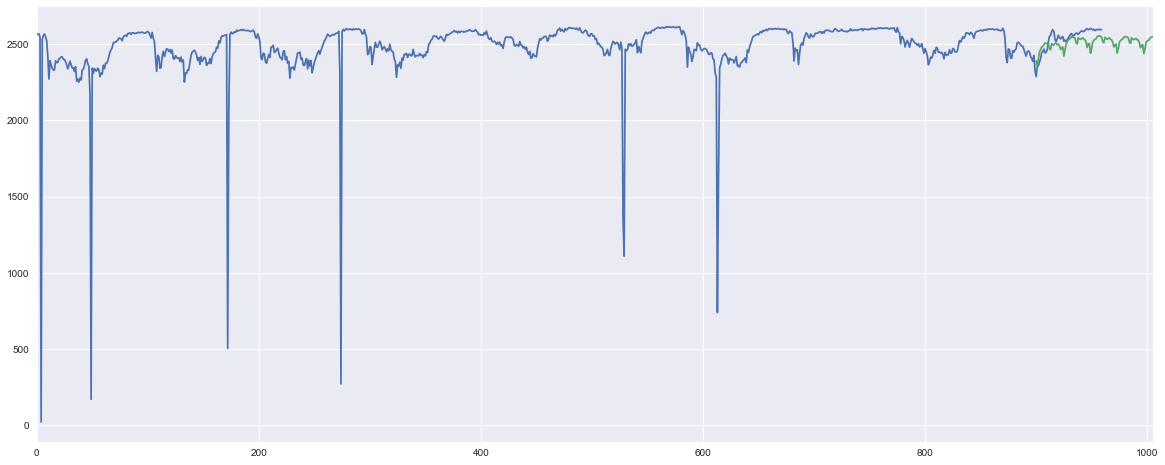

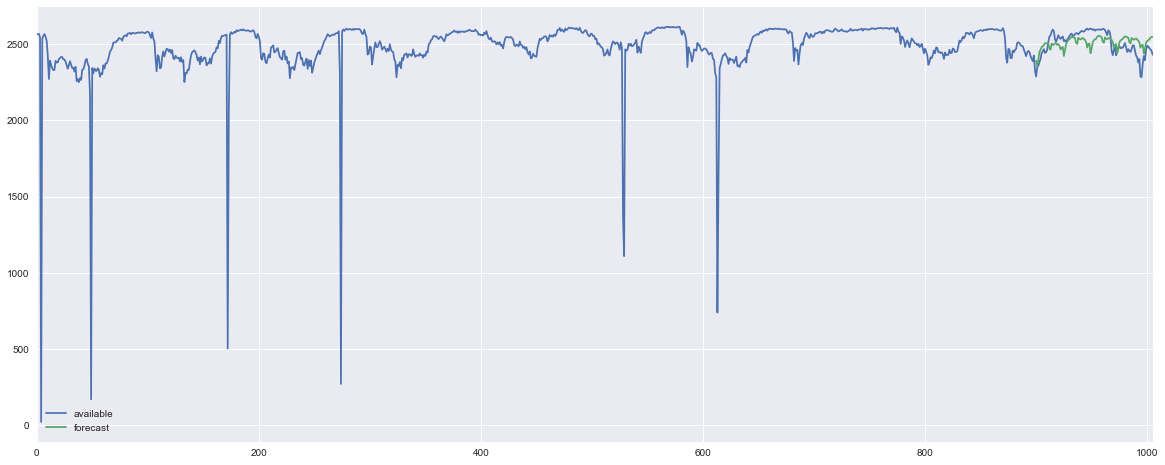

In [109]:
data = df.reset_index()
data['forecast'] = results.predict(start = 900, end= 1006, dynamic=True)
data.available.iloc[:960].plot()
data.forecast.plot(figsize=(20,8))
data[['available', 'forecast']].plot(figsize=(20, 8)) 

#### ^^^ The ACF/PACF method doesn't seem to have worked for us.

In [38]:
mod = sm.tsa.statespace.SARIMAX(df[0:960].available, trend='n', order=(1,0,1), seasonal_order=(1,0,1,4))
results = mod.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                         available   No. Observations:                  960
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 4)   Log Likelihood               -6352.774
Date:                           Tue, 20 Mar 2018   AIC                          12715.549
Time:                                   19:26:19   BIC                          12739.883
Sample:                               02-20-2018   HQIC                         12724.816
                                    - 03-02-2018                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9995      0.001   1791.766      0.000       0.998       1.001
ma.L1         -0.8593      0.015    -58.435      0.000      -0.888      -0.830
ar.S.L4        0.9997      0.001   1579.969      0.000       0.999       1.001
ma.S.L4       -0.9864      0.017    -57.466      0.000      -1.020      -0.953
sigma2      3.722e+04    377.442     98.619      0.000    3.65e+04     3.8e+04
===================================================================================
Ljung-Box (Q):                       39.74   Jarque-Bera (JB):            423432.33
Prob(Q):                              0.48   Prob(JB):                         0.00
Heteroskedasticity (H):               0.03   Skew:                            -8.79
Prob(H) (two-sided):                  0.00   Kurtosis:                       104.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

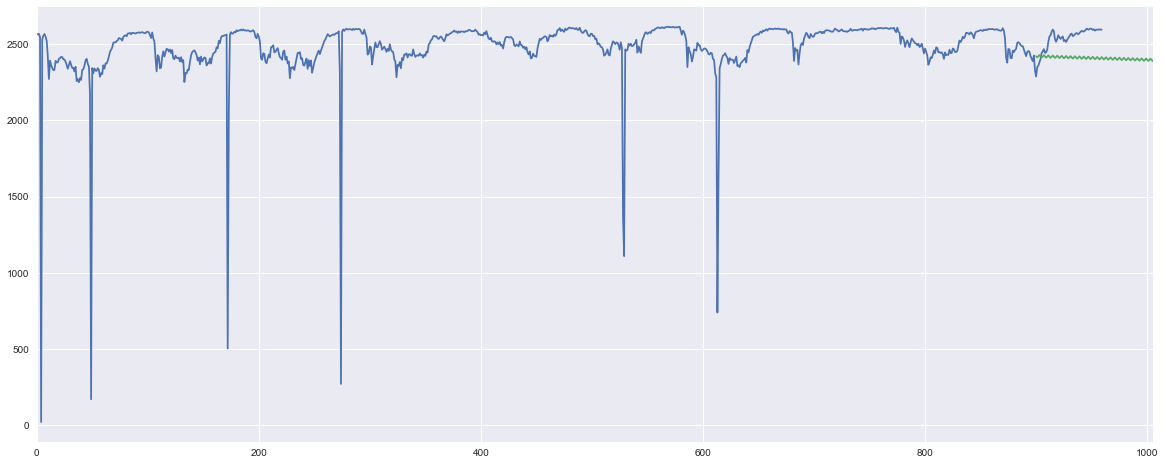

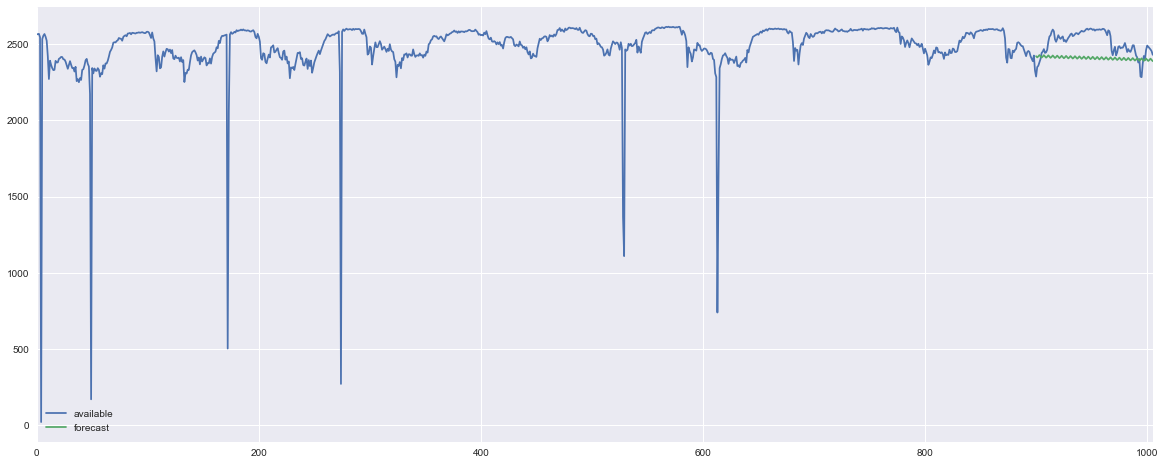

In [39]:
data = df.reset_index()
data['forecast'] = results.predict(start = 900, end= 1006, dynamic=True)
data.available.iloc[:960].plot()
data.forecast.plot(figsize=(20,8))
data[['available', 'forecast']].plot(figsize=(20, 8)) 

#### ^^^ we have a ton of statistically significant lags, but the prediction stinks.

In [81]:
mod = sm.tsa.statespace.SARIMAX(df[0:960].available, trend='n', order=(1,0,0), seasonal_order=(1,1,7,24), enforce_invertibility = False)
results = mod.fit()
results.summary()

/Users/nmolivo/anaconda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                          available   No. Observations:                  960
Model:             SARIMAX(1, 0, 0)x(1, 1, 7, 24)   Log Likelihood               -6207.002
Date:                            Tue, 20 Mar 2018   AIC                          12434.004
Time:                                    20:53:47   BIC                          12482.673
Sample:                                02-20-2018   HQIC                         12452.538
                                     - 03-02-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3484      0.011     30.503      0.000       0.326       0.371
ar.S.L24      -0.8730      0.044    -19.894      0.000      -0.959      -0.787
ma.S.L24       0.0318      0.044      0.717      0.473      -0.055       0.119
ma.S.L48      -0.8885      0.049    -18.184      0.000      -0.984      -0.793
ma.S.L72       0.0017      0.026      0.066      0.947      -0.049       0.052
ma.S.L96       0.0688      0.020      3.489      0.000       0.030       0.108
ma.S.L120     -0.0211      0.034     -0.626      0.531      -0.087       0.045
ma.S.L144     -0.0807      0.031     -2.614      0.009      -0.141      -0.020
ma.S.L168      0.1533      0.028      5.483      0.000       0.099       0.208
sigma2      3.145e+04   2443.845     12.870      0.000    2.67e+04    3.62e+04
===================================================================================
Ljung-Box (Q):                       81.85   Jarque-Bera (JB):            144941.66
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.06   Skew:                            -3.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        63.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [82]:
data = df.reset_index()

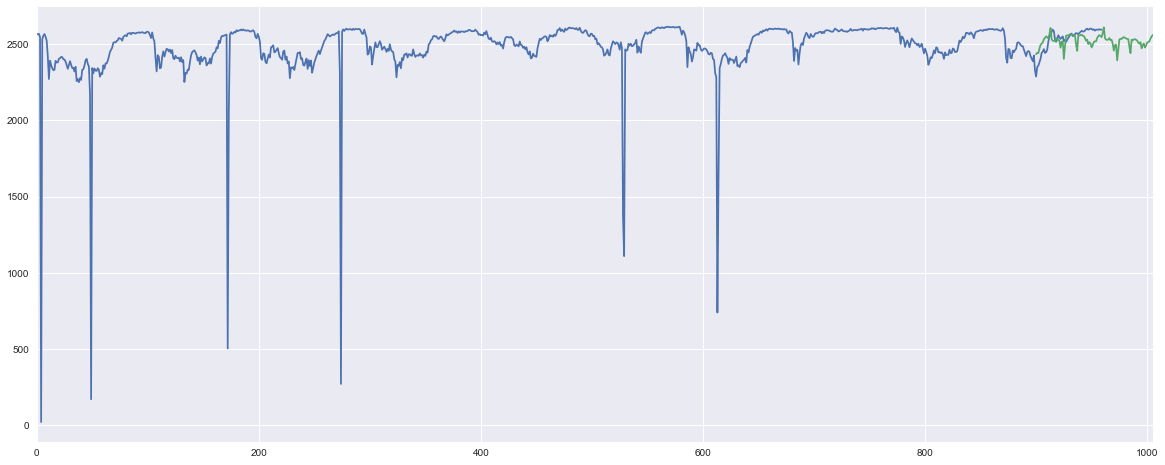

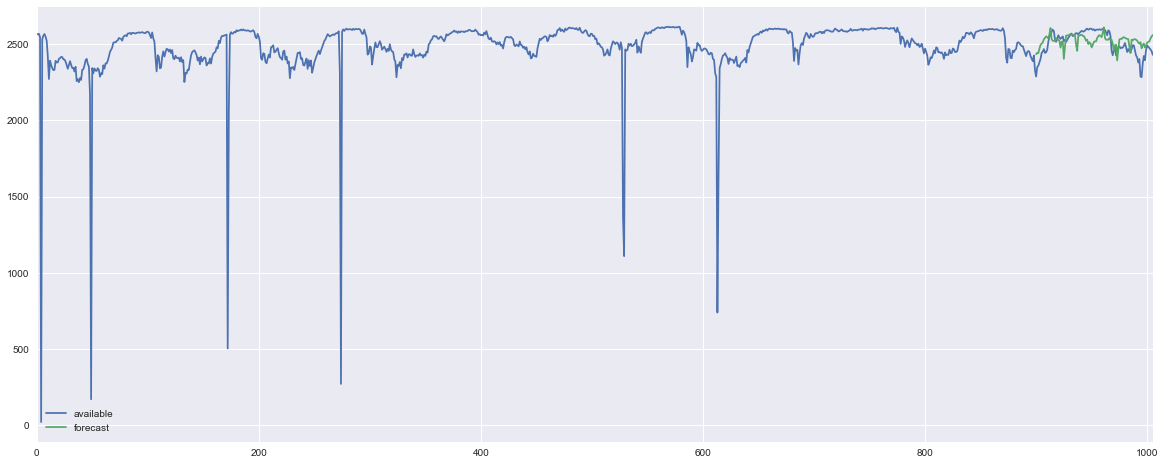

In [83]:
data['forecast'] = results.predict(start = 900, end= 1006, dynamic=True)
data.available.iloc[:960].plot()
data.forecast.plot(figsize=(20,8))
data[['available', 'forecast']].plot(figsize=(20, 8)) 

#### ^^^ wow this looks much better, and there are plenty of statistically significant lags. but it's almost as if it predicts a divot too frequently

In [104]:
mod = sm.tsa.statespace.SARIMAX(df[0:960].available, trend='n', order=(1,0,1), seasonal_order=(1,1,7,24), enforce_invertibility = False)
results = mod.fit()
results.summary()

/Users/nmolivo/anaconda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                          available   No. Observations:                  960
Model:             SARIMAX(1, 0, 1)x(1, 1, 7, 24)   Log Likelihood               -6204.103
Date:                            Tue, 20 Mar 2018   AIC                          12430.206
Time:                                    21:42:02   BIC                          12483.742
Sample:                                02-20-2018   HQIC                         12450.594
                                     - 03-02-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9998      0.000   2345.173      0.000       0.999       1.001
ma.L1         -0.8859      0.011    -84.340      0.000      -0.907      -0.865
ar.S.L24      -0.9972      0.022    -44.854      0.000      -1.041      -0.954
ma.S.L24       0.0159      0.066      0.242      0.809      -0.113       0.145
ma.S.L48      -1.0560      0.025    -41.667      0.000      -1.106      -1.006
ma.S.L72       0.0478      0.021      2.329      0.020       0.008       0.088
ma.S.L96       0.0642      0.023      2.782      0.005       0.019       0.109
ma.S.L120     -0.0537      0.027     -1.973      0.048      -0.107      -0.000
ma.S.L144      0.0241      0.026      0.937      0.349      -0.026       0.074
ma.S.L168      0.0218      0.022      0.982      0.326      -0.022       0.065
sigma2      3.159e+04   3.37e-06   9.37e+09      0.000    3.16e+04    3.16e+04
===================================================================================
Ljung-Box (Q):                       63.19   Jarque-Bera (JB):            163629.58
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               0.05   Skew:                            -4.11
Prob(H) (two-sided):                  0.00   Kurtosis:                        67.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.91e+24. Standard errors may be unstable.
"""

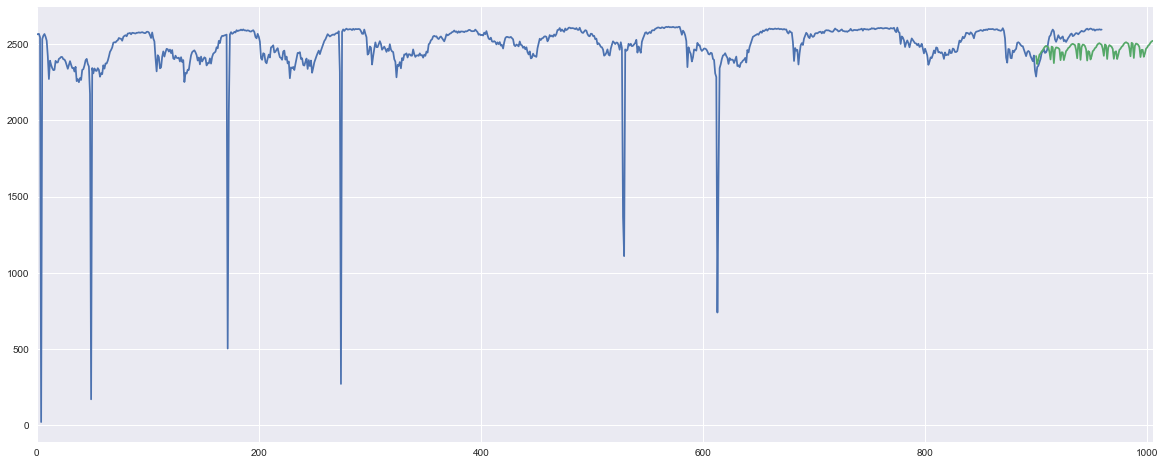

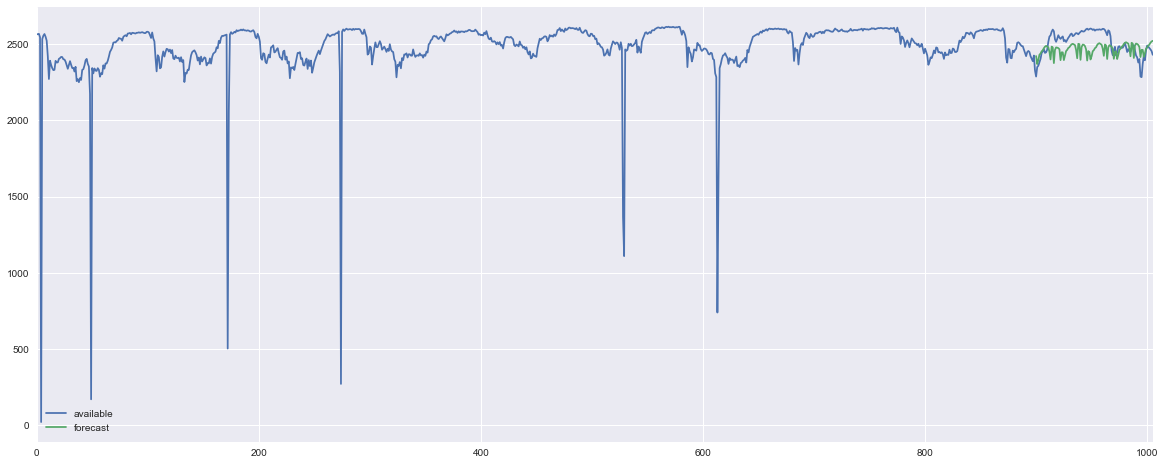

In [105]:
data = df.reset_index()
data['forecast'] = results.predict(start = 900, end= 1006, dynamic=True)
data.available.iloc[:960].plot()
data.forecast.plot(figsize=(20,8))
data[['available', 'forecast']].plot(figsize=(20, 8)) 

In [79]:
mod = sm.tsa.statespace.SARIMAX(df[0:960].available, trend='n', order=(4,0,4), seasonal_order=(1,0,1,4), 
                                enforce_stationarity =False, enforce_invertibility = False)
results = mod.fit()
results.summary()

/Users/nmolivo/anaconda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                         available   No. Observations:                  960
Model:             SARIMAX(4, 0, 4)x(1, 0, 1, 4)   Log Likelihood               -6147.771
Date:                           Tue, 20 Mar 2018   AIC                          12317.543
Time:                                   20:32:51   BIC                          12371.079
Sample:                               02-20-2018   HQIC                         12337.931
                                    - 03-02-2018                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2797      0.222      1.257      0.209      -0.156       0.716
ar.L2          0.0939      0.081      1.158      0.247      -0.065       0.253
ar.L3          0.2893      0.369      0.784      0.433      -0.434       1.012
ar.L4          0.3371      0.575      0.587      0.557      -0.789       1.463
ma.L1          0.0852      0.220      0.387      0.699      -0.346       0.516
ma.L2         -0.0372      0.115     -0.323      0.747      -0.263       0.189
ma.L3         -0.2284      0.401     -0.569      0.569      -1.014       0.558
ma.L4          0.0039      0.280      0.014      0.989      -0.545       0.553
ar.S.L4       -0.0629      0.252     -0.249      0.803      -0.558       0.432
ma.S.L4       -0.3002      0.448     -0.671      0.502      -1.177       0.577
sigma2      2.429e+04    388.282     62.560      0.000    2.35e+04    2.51e+04
===================================================================================
Ljung-Box (Q):                       22.24   Jarque-Bera (JB):            633404.25
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.02   Skew:                            -9.43
Prob(H) (two-sided):                  0.00   Kurtosis:                       128.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

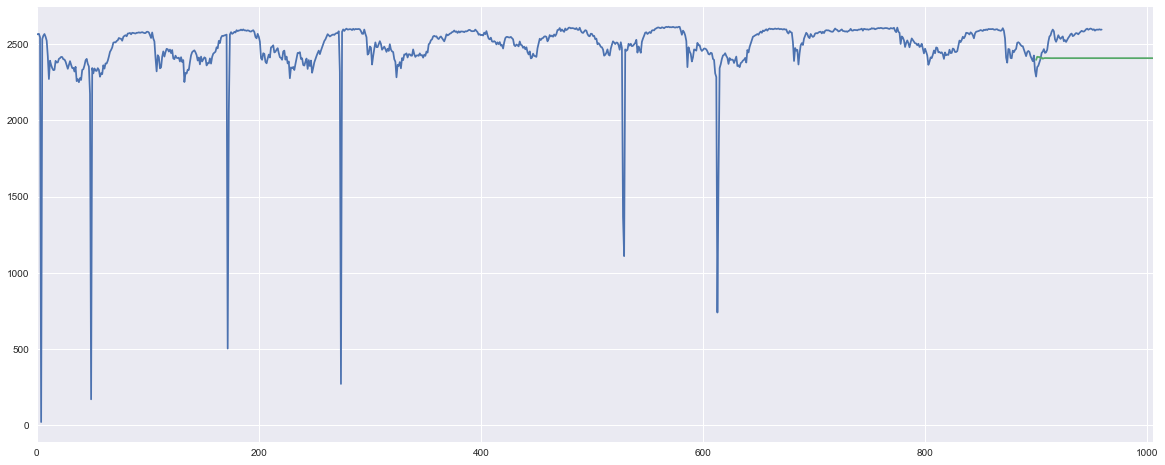

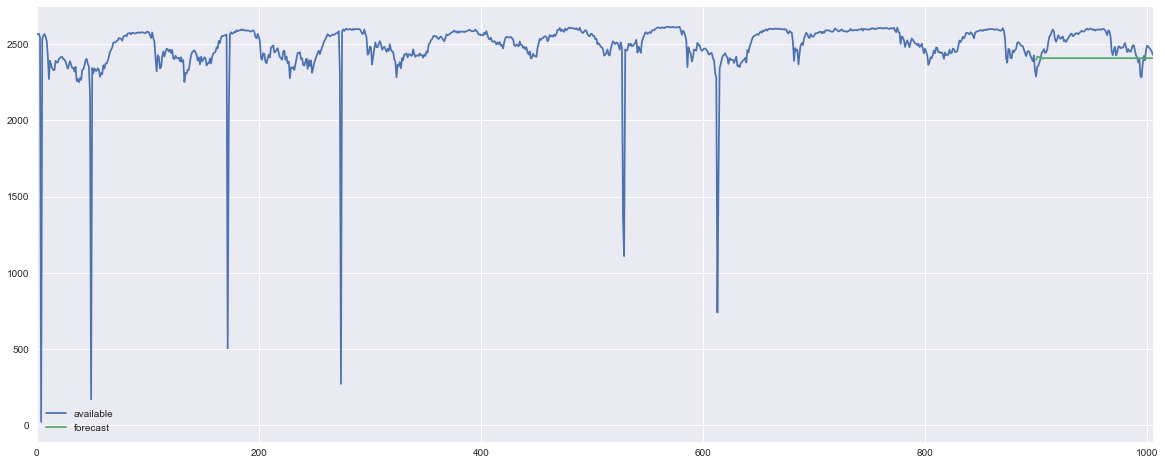

In [80]:
data = df.reset_index()
data['forecast'] = results.predict(start = 900, end= 1006, dynamic=True)
data.available.iloc[:960].plot()
data.forecast.plot(figsize=(20,8))
data[['available', 'forecast']].plot(figsize=(20, 8)) 

In [163]:
mod = sm.tsa.statespace.SARIMAX(df[0:960].available, trend='n', order=(1,0,1), seasonal_order=(4,0,7,24), 
                                enforce_stationarity =False, enforce_invertibility = False)
results = mod.fit()
results.summary()

/Users/nmolivo/anaconda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                          available   No. Observations:                  960
Model:             SARIMAX(1, 0, 1)x(4, 0, 7, 24)   Log Likelihood               -5119.394
Date:                            Tue, 13 Mar 2018   AIC                          10266.789
Time:                                    14:41:50   BIC                          10334.926
Sample:                                02-20-2018   HQIC                         10292.737
                                     - 03-02-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3883      0.133      2.922      0.003       0.128       0.649
ma.L1          0.0011      0.136      0.008      0.993      -0.266       0.268
ar.S.L24       0.3495      0.252      1.385      0.166      -0.145       0.844
ar.S.L48      -0.1250      0.180     -0.695      0.487      -0.478       0.228
ar.S.L72       0.2563      0.240      1.070      0.285      -0.213       0.726
ar.S.L96       0.5220      0.271      1.923      0.054      -0.010       1.054
ma.S.L24      -0.2833      0.253     -1.119      0.263      -0.780       0.213
ma.S.L48       0.1472      0.191      0.769      0.442      -0.228       0.522
ma.S.L72      -0.1789      0.272     -0.658      0.510      -0.712       0.354
ma.S.L96      -0.4762      0.273     -1.744      0.081      -1.011       0.059
ma.S.L120     -0.0210      0.066     -0.317      0.751      -0.151       0.109
ma.S.L144     -0.0155      0.134     -0.115      0.908      -0.279       0.248
ma.S.L168      0.0391      0.067      0.587      0.557      -0.091       0.169
sigma2      3.727e+04   1744.661     21.361      0.000    3.38e+04    4.07e+04
===================================================================================
Ljung-Box (Q):                       36.65   Jarque-Bera (JB):            412175.44
Prob(Q):                              0.62   Prob(JB):                         0.00
Heteroskedasticity (H):               0.07   Skew:                            -8.42
Prob(H) (two-sided):                  0.00   Kurtosis:                       113.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [164]:
predictions = pd.DataFrame(results.predict(start = 900, end= 1006, dynamic=True))
predictions.columns = ["forecast"]
data = df.reset_index()
data.drop('forecast', axis =1, inplace=True)
data = data.join(predictions)

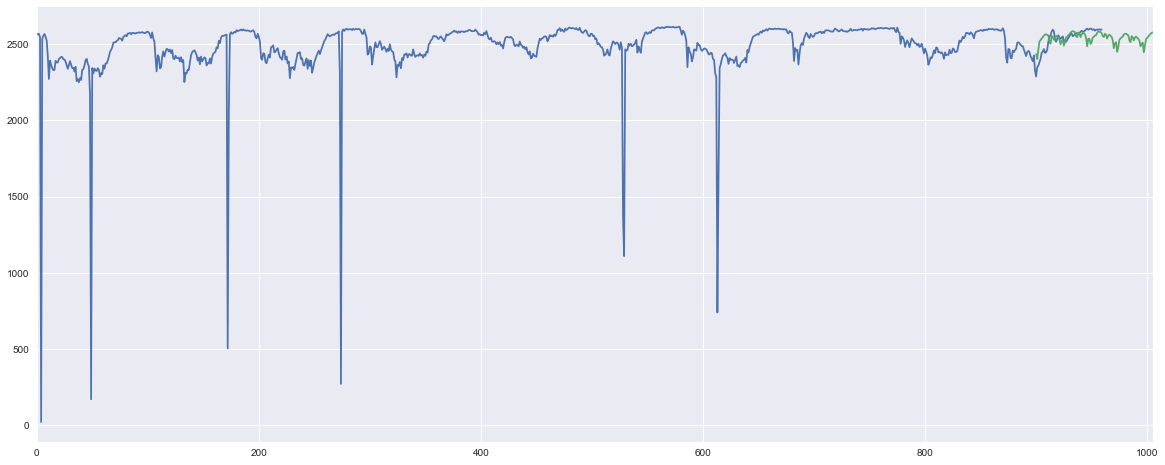

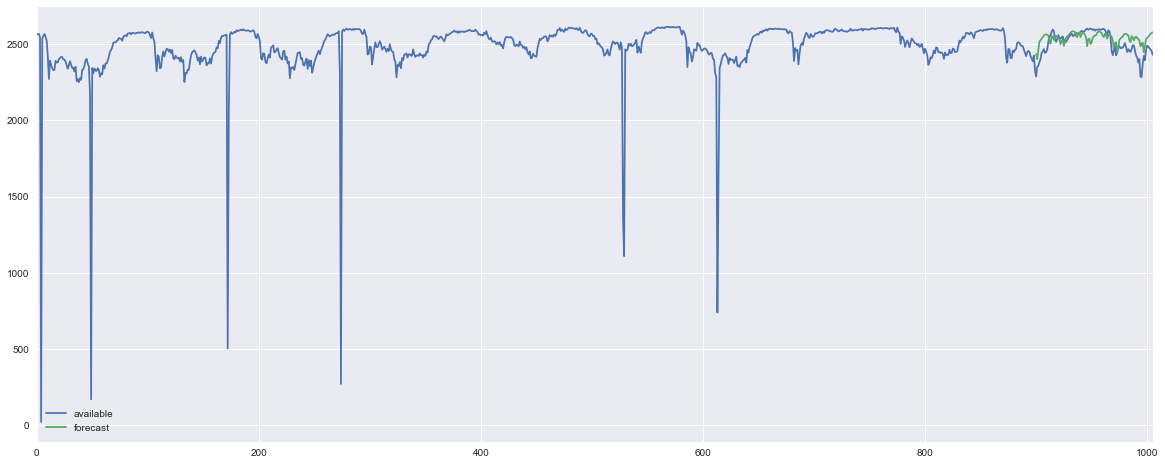

In [165]:
data['forecast'] = results.predict(start = 900, end= 1006, dynamic=True)
data.available.iloc[:960].plot()
data.forecast.plot(figsize=(20,8))
data[['available', 'forecast']].plot(figsize=(20, 8)) 
#plt.savefig('ts_df_predict.png', bbox_inches='tight')

#### <font color = 'red'>^^^ I think this one is the winner, for predictions, anyways.</font>

In [110]:
mod = sm.tsa.statespace.SARIMAX(df[0:960].available, trend='n', order=(1,0,0), seasonal_order=(4,0,7,24), enforce_invertibility = False)
results = mod.fit()
results.summary()

/Users/nmolivo/anaconda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                          available   No. Observations:                  960
Model:             SARIMAX(1, 0, 0)x(4, 0, 7, 24)   Log Likelihood               -6512.028
Date:                            Tue, 20 Mar 2018   AIC                          13050.057
Time:                                    23:16:50   BIC                          13113.327
Sample:                                02-20-2018   HQIC                         13074.151
                                     - 03-02-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9962      0.007    135.149      0.000       0.982       1.011
ar.S.L24      -0.0051      0.408     -0.012      0.990      -0.805       0.795
ar.S.L48       0.1887      0.338      0.558      0.577      -0.474       0.852
ar.S.L72       0.4344      0.315      1.381      0.167      -0.182       1.051
ar.S.L96       0.3801      0.395      0.961      0.337      -0.395       1.155
ma.S.L24       0.0008      0.360      0.002      0.998      -0.704       0.706
ma.S.L48      -0.1931      0.337     -0.573      0.567      -0.854       0.468
ma.S.L72      -0.4225      0.314     -1.346      0.178      -1.038       0.193
ma.S.L96      -0.4063      0.327     -1.243      0.214      -1.047       0.235
ma.S.L120     -0.0854      0.116     -0.739      0.460      -0.312       0.141
ma.S.L144     -0.0972      0.099     -0.983      0.326      -0.291       0.097
ma.S.L168      0.1880      0.106      1.779      0.075      -0.019       0.395
sigma2      4.727e+04    1.4e-05   3.38e+09      0.000    4.73e+04    4.73e+04
===================================================================================
Ljung-Box (Q):                      154.59   Jarque-Bera (JB):            289492.04
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.02   Skew:                             0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                        88.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.06e+25. Standard errors may be unstable.
"""

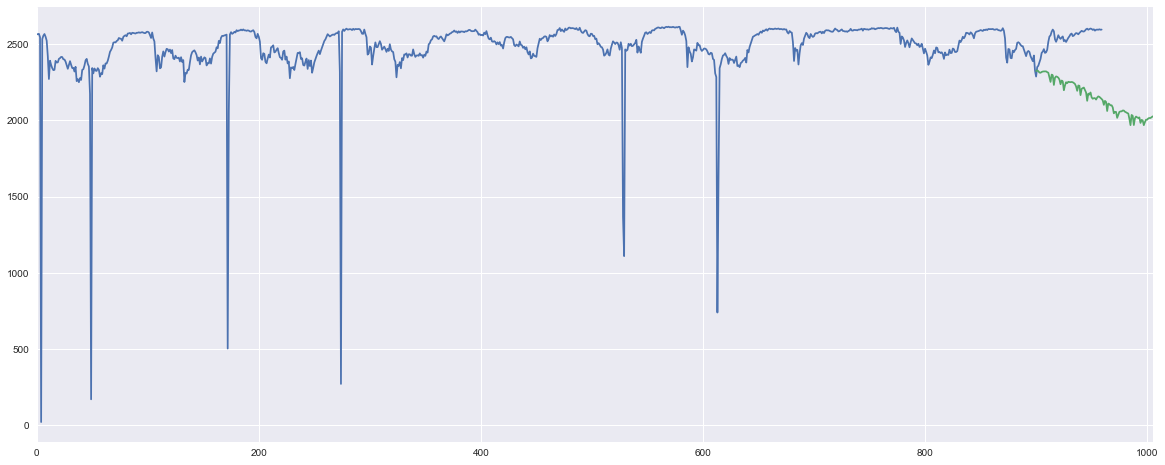

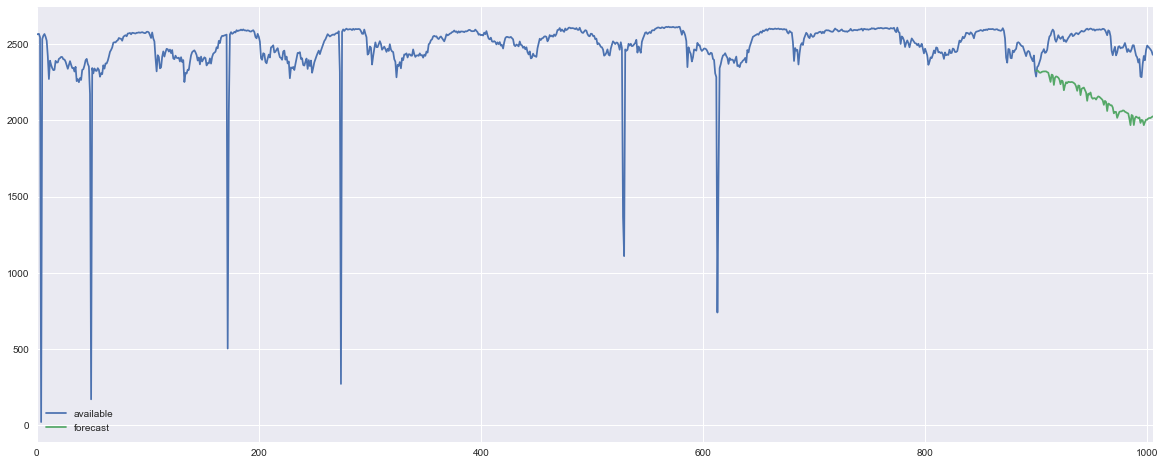

In [112]:
data = df.reset_index()
data['forecast'] = results.predict(start = 900, end= 1006, dynamic=True)
data.available.iloc[:960].plot()
data.forecast.plot(figsize=(20,8))
data[['available', 'forecast']].plot(figsize=(20, 8)) 

#### ^^ wow when we take away that seemingly non-statistically significant MA value (q), this model quickly turns to garbage.

In [119]:
mod = sm.tsa.statespace.SARIMAX(df[0:960].available, trend='n', order=(1,0,1), seasonal_order=(4,0,8,24), 
                                enforce_stationarity =False, enforce_invertibility = False)
results = mod.fit()
results.summary()

/Users/nmolivo/anaconda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                          available   No. Observations:                  960
Model:             SARIMAX(1, 0, 1)x(4, 0, 8, 24)   Log Likelihood               -4915.725
Date:                            Wed, 21 Mar 2018   AIC                           9861.451
Time:                                    00:12:27   BIC                           9934.455
Sample:                                02-20-2018   HQIC                          9889.252
                                     - 03-02-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9999      0.003    347.609      0.000       0.994       1.006
ma.L1         -0.7540      0.019    -39.012      0.000      -0.792      -0.716
ar.S.L24      -0.0126      0.635     -0.020      0.984      -1.257       1.232
ar.S.L48      -0.0163      0.300     -0.054      0.957      -0.605       0.572
ar.S.L72      -0.0011      0.356     -0.003      0.998      -0.699       0.697
ar.S.L96       0.1039      0.092      1.124      0.261      -0.077       0.285
ma.S.L24       0.0404      0.655      0.062      0.951      -1.244       1.325
ma.S.L48       0.0111      0.378      0.029      0.977      -0.731       0.753
ma.S.L72       0.0360      0.404      0.089      0.929      -0.757       0.829
ma.S.L96      -0.1124      0.201     -0.558      0.577      -0.507       0.282
ma.S.L120      0.0009      0.390      0.002      0.998      -0.764       0.766
ma.S.L144      0.0004      0.486      0.001      0.999      -0.952       0.952
ma.S.L168      0.0077      0.341      0.023      0.982      -0.662       0.677
ma.S.L192      0.0099      0.342      0.029      0.977      -0.661       0.680
sigma2      3.729e+04   1467.100     25.418      0.000    3.44e+04    4.02e+04
===================================================================================
Ljung-Box (Q):                       70.30   Jarque-Bera (JB):            723417.54
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.04   Skew:                            -9.89
Prob(H) (two-sided):                  0.00   Kurtosis:                       152.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

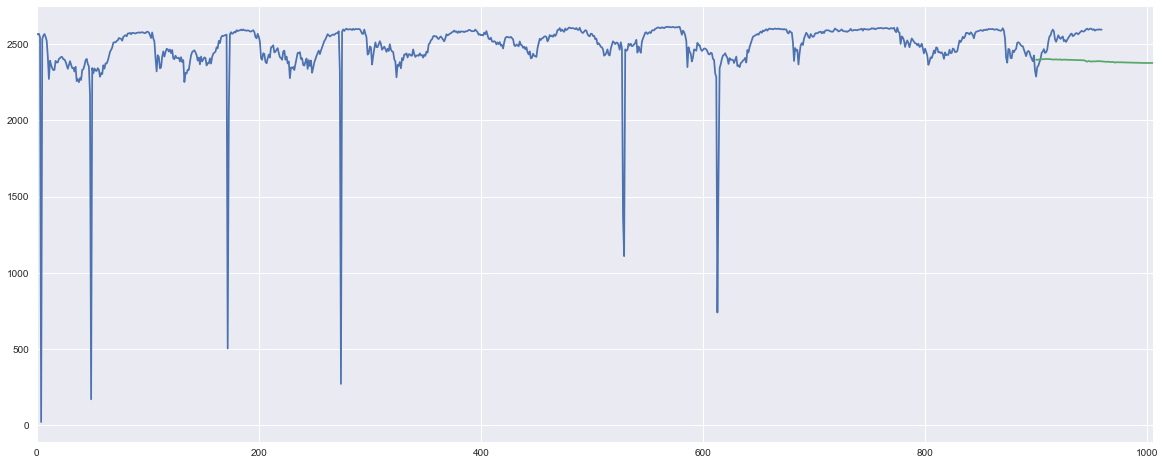

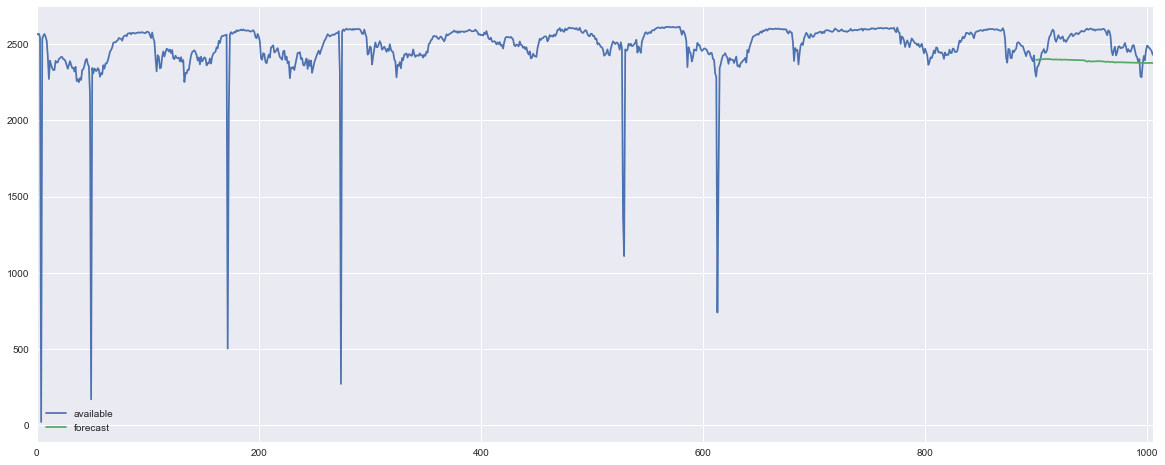

In [118]:
data = df.reset_index()
data['forecast'] = results.predict(start = 900, end= 1006, dynamic=True)
data.available.iloc[:960].plot()
data.forecast.plot(figsize=(20,8))
data[['available', 'forecast']].plot(figsize=(20, 8)) 